In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np

import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.t8btag_minmass
table.csv = 't8btag_minmass'

signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - Top 8 Btagged jets selected

In [3]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

# MC Reweighting
## MC Background normalization needs to be corrected to match data normalization
## A rough correction of 2.3x is applied along with a 20\% uncertainty

In [4]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

In [5]:
def jet_ht(t):
    t.extend(
        jet_ht=ak.sum(t.jet_ptRegressed,axis=-1)
    )
(signal+bkg).apply(jet_ht)

[None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


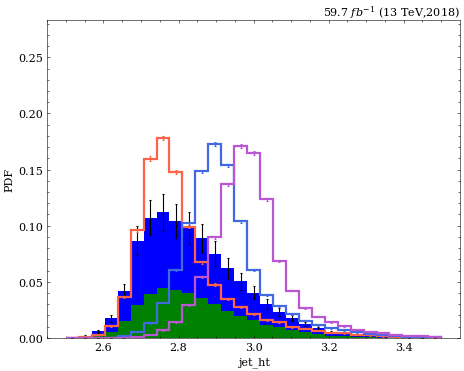

In [20]:
histos = obj_store()
study.quick(
    signal+bkg,
    h_transform=np.log10,
    efficiency=True,
    varlist=['jet_ht'],
    binlist=[(2.5, 3.5, 30)],
    store=histos,
)

In [105]:
class flat_reweighter:
    def __init__(self, feature='jet_ht', transform=np.log10, bins=None):
        self.feature = feature
        self.transform = transform
        self.bins = bins

    def get_features(self, trees : ObjIter):
        if not isinstance(trees, ObjIter):
            trees = ObjIter([trees])

        X = getattr(trees, self.feature).cat
        if self.transform is not None:
            X = self.transform(X)
        W = getattr(trees, 'scale').cat
        return X, W

    def fit(self, trees : ObjIter):
        X, W = self.get_features(trees)

        histo = Histo(X, bins=self.bins, weights=W, efficiency=True)

        Y = 1/histo.histo 
        Y[ np.isinf(Y) ] = np.max( Y[~np.isinf(Y)] )
        Y /= np.sum(Y)
        
        self.reweighter = Graph( get_bin_centers(histo.bins), Y)
        return self

    def reweight_trees(self, trees : ObjIter):
        X,_ = self.get_features(trees)
        return self.reweighter.evaluate(X)



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


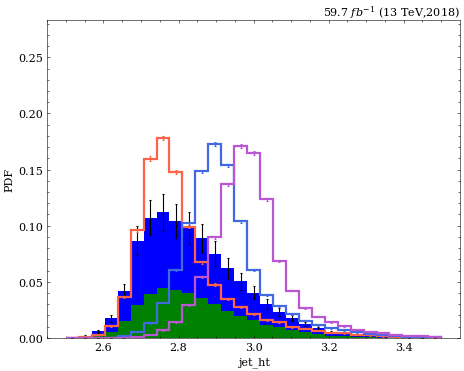

In [106]:
study.quick(
    signal+bkg,
    h_transform=np.log10,
    efficiency=True,
    varlist=['jet_ht'],
    binlist=[(2.5, 3.5, 30)],
)

In [115]:
bkg_reweight = flat_reweighter('jet_ht', transform=np.log10, bins=(2.5,3.5,10)).fit(bkg)

In [116]:
signal_reweight = signal.apply(flat_reweighter('jet_ht', transform=np.log10, bins=(2.5,3.5,10)).fit)

100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


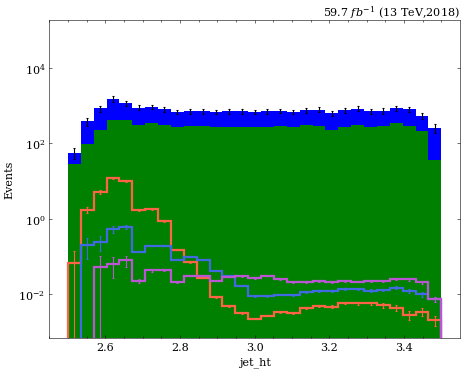

In [119]:
study.quick(
    signal+bkg,
    scale=[reweight.reweight_trees for reweight in signal_reweight]+[bkg_reweight.reweight_trees]*len(bkg),
    h_transform=np.log10,
    log=True,
    # efficiency=True,
    varlist=['jet_ht'],
    binlist=[(2.5, 3.5, 30)],
)